# Implementation of the paper: MNIST with MPS quantum network

Dilip et al. Data compression for quantum machine learning


https://arxiv.org/abs/2204.11170




## Libraries

In [ ]:
from sklearn.datasets import make_moons
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer
from scipy.stats import norm
from time import time

In [ ]:
import numpy as onp

## Bin MNIST Data Set

In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
# Select the indices for the binary classification
y_train = y_train
y_test = y_test

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
# Select the indices for the binary classification

X_train = X_train[(y_train == 3) | (y_train == 6)]
y_train = y_train[(y_train == 3) | (y_train == 6)]
X_test = X_test[(y_test == 3) | (y_test == 6)]
y_test = y_test[(y_test == 3) | (y_test == 6)]

X_train.shape, y_train.shape

((12049, 28, 28), (12049,))

((12049, 16), (12049, 2), (1968, 16), (1968, 2))

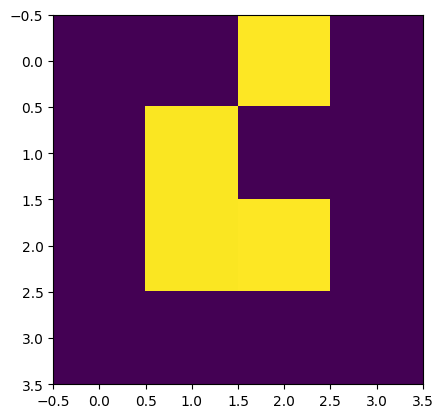

In [ ]:
X_train = tf.image.resize(np.expand_dims(X_train, 3), (4, 4)).numpy().squeeze()
X_test = tf.image.resize(np.expand_dims(X_test, 3), (4, 4)).numpy().squeeze()

plt.imshow(X_train[59])

# reshape the X_train_n , and X_test_n,
n_train = X_train.shape[0]
n_test = X_test.shape[0]
l_side = X_test.shape[1]
X_train = X_train.reshape((n_train, l_side**2))/255
X_test = X_test.reshape((n_test, l_side**2))/255

## one hot encode the labels
y_train_oh = np.zeros((len(y_train), 2))
y_test_oh = np.zeros((len(y_test), 2))
labels_train = np.zeros((len(y_train), 1))
labels_test = np.zeros((len(y_test), 1))

for i in range(len(y_train)):
  if y_train[i] == 3:
    y_train_oh[i] = np.array([1, 0])
  else:
    y_train_oh[i] = np.array([0, 1])
    labels_train[i] = 1

for i in range(len(y_test)):
  if y_test[i] == 3:
    y_test_oh[i] = np.array([1, 0])
  else:
    y_test_oh[i] = np.array([0, 1])
    labels_test[i] = 1

X_train.shape, y_train_oh.shape, X_test.shape, y_test_oh.shape

In [ ]:
# Organize the features in a snake form

X_train_feat = np.zeros_like(X_train)
X_test_feat = np.zeros_like(X_test)
for i in range(len(X_train)):
  X_train_feat[i] = np.concatenate([X_train[i, :4], np.flip(X_train[i, 4:8]), X_train[i, 8:12], np.flip(X_train[i, 12:16])])

for i in range(len(X_test)):
  X_test_feat[i] = np.concatenate([X_test[i, :4], np.flip(X_test[i, 4:8]), X_test[i, 8:12], np.flip(X_test[i, 12:16])])

## apply the FRQI mapping

X_train_quantum_feat = np.zeros((X_train.shape[0], 2*X_train.shape[1]))
X_test_quantum_feat = np.zeros((X_test.shape[0], 2*X_test.shape[1]))

for i in range(X_train_feat.shape[1]):
  X_train_quantum_feat[:, 2*i], X_train_quantum_feat[:, 2*i + 1] = np.cos(np.pi*X_train_feat[:, i]/2), np.sin(np.pi*X_train_feat[:, i]/2)

for i in range(X_test_feat.shape[1]):
  X_test_quantum_feat[:, 2*i], X_test_quantum_feat[:, 2*i + 1] = np.cos(np.pi*X_test_feat[:, i]/2), np.sin(np.pi*X_test_feat[:, i]/2)


X_train_quantum_feat /= np.sqrt(X_train_feat.shape[1])
X_test_quantum_feat /= np.sqrt(X_test_feat.shape[1])

X_test_quantum_feat.shape, X_train_quantum_feat.shape

((1968, 32), (12049, 32))

### Pennylane prediction

In [ ]:
dev = qml.device("lightning.qubit", wires = 5)

@qml.qnode(dev)
def Dilip_MPS_variational(mps_params, image_feat_param):

  qml.MottonenStatePreparation(state_vector=image_feat_param, wires=range(5))

  # MPS Layer 1

  qml.ArbitraryUnitary(mps_params[0], wires = [3, 4])
  qml.ArbitraryUnitary(mps_params[1], wires = [2, 3])
  qml.ArbitraryUnitary(mps_params[2], wires = [1, 2])
  qml.ArbitraryUnitary(mps_params[3], wires = [0, 1])

  # MPS Layer 2

  qml.ArbitraryUnitary(mps_params[4], wires = [3, 4])
  qml.ArbitraryUnitary(mps_params[5], wires = [2, 3])
  qml.ArbitraryUnitary(mps_params[6], wires = [1, 2])
  qml.ArbitraryUnitary(mps_params[7], wires = [0, 1])

  return qml.probs(wires=[0])

In [ ]:
## taken from https://stackoverflow.com/questions/67615051/implementing-binary-cross-entropy-loss-gives-different-answer-than-tensorflows

def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [ ]:
def mps_variational_classifier(mps_params, x1s):
    preds= Dilip_MPS_variational(mps_params, x1s)
    pred_1 = preds[1] / (preds[1] + preds[0])
    return pred_1


In [ ]:
def cost(mps_params, features, labels):
    predictions = [mps_variational_classifier(mps_params, x1s) for x1s in features]
    return BinaryCrossEntropy(labels, predictions)

### Training MPS variational classifier

In [ ]:
# 4 feaatures

# Experiment method 5

var_init_mps_randominit = np.random.rand(8, 15)

opt = qml.AdamOptimizer(stepsize = 0.001) # original 0.001
batch_size = 5
num_train = len(X_train_quantum_feat)

# train the variational classifier
var_mps = var_mps_986its

exp_time = time()
for it in range(986, 12001):

    # Gradient descent step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = X_train_quantum_feat[batch_index]
    Y_train_batch = labels_train[batch_index]
    var_mps = opt.step(lambda v_mps: cost(v_mps, feats_train_batch, Y_train_batch), var_mps)


    if it % 100 == 0:
      print(it)
      print("cost:", cost(var_mps, feats_train_batch, Y_train_batch))
      print(repr(var_mps))
      print(f"--------time VarQMC Epoch: {it}---------------")
      print(time() - exp_time)
      exp_time = time()

    if it % 800 == 0:
      print(it)
      print("cost:", cost(var_mps, X_train_quantum_feat[:200], labels_train[:200]))
      print(repr(var_mps))

1000
cost: [0.51597456]
tensor([[ 0.83299639,  0.63423448,  0.10022679,  1.0841575 ,  0.56833078,
          0.12848035,  0.64237409,  0.18373229,  0.81362353,  0.22555572,
          0.87062365,  0.38520188,  0.31163507,  0.95529293,  0.25748925],
        [ 0.66080592,  0.60440841,  0.6347893 ,  0.06845689,  0.52299896,
          0.69102484,  0.60809382,  0.52586458,  0.44267817,  0.07833746,
          0.46654743,  0.56001184,  0.08279575,  0.57117647,  0.74314489],
        [ 0.13752271,  0.0544641 ,  0.29711185,  0.55325004,  0.12799357,
          0.79775862,  0.53784024,  1.01282595,  0.94936009,  0.33208226,
          0.82045593,  0.82917052,  0.65898273,  0.02681852, -0.14068317],
        [ 0.70074276,  0.17065604,  0.30963038,  0.44249012,  0.00302629,
          0.64811309,  0.46207154, -0.10426294,  0.39210542,  0.2563704 ,
          0.67762717,  0.09225567,  1.01026318, -0.15989706, -0.07596536],
        [ 0.81688594,  0.55246915,  0.78081479,  0.79423246,  0.91274484,
          

KeyboardInterrupt: ignored

In [ ]:
var_mps_30its = np.array([[0.71060912, 0.58304032, 0.0871209 , 0.98788839, 0.6622734 ,
         0.23322513, 0.54650181, 0.05646772, 0.65325278, 0.61298476,
         0.44921786, 0.2935209 , 0.14681468, 0.69755321, 0.39330737],
        [0.68378935, 0.66103546, 0.86662613, 0.22129978, 0.51266245,
         0.57051085, 0.44747002, 0.77408729, 0.31077888, 0.06351385,
         0.50495245, 0.41723754, 0.10687544, 0.51966911, 0.58496273],
        [0.18651484, 0.11610003, 0.26997205, 0.5494953 , 0.14988585,
         0.71134314, 0.57295597, 0.8287852 , 0.90399489, 0.37276146,
         0.83238258, 0.83875033, 0.68228682, 0.00286311, 0.08566515],
        [0.53066005, 0.1299117 , 0.29233262, 0.40806596, 0.11330963,
         0.79078632, 0.48456415, 0.01226469, 0.52641923, 0.25748825,
         0.67161038, 0.10031573, 0.98855772, 0.00108739, 0.00858821],
        [0.8068659 , 0.64045322, 0.78978872, 0.76687716, 0.99872844,
         0.76858568, 0.34668329, 0.07419893, 0.84748303, 0.43048426,
         0.8180286 , 0.72536634, 0.1135534 , 0.09829628, 0.94123744],
        [0.64685499, 0.87053124, 0.98312547, 0.04155312, 0.3206519 ,
         0.16640738, 0.66864035, 0.99641792, 0.1321707 , 0.14688426,
         0.10927005, 0.64039381, 0.38000363, 0.84714477, 0.23449038],
        [0.43855002, 0.01473589, 0.22862548, 0.86707878, 0.98482433,
         0.78259046, 0.75868302, 0.87249852, 0.07253795, 0.53867922,
         0.33970598, 0.44979102, 0.64568712, 0.66785061, 0.41518368],
        [0.29161437, 0.52754027, 0.42951017, 0.93719471, 0.43872615,
         0.27483469, 0.86885282, 0.69265612, 0.79838924, 0.42130754,
         0.08476825, 0.3924509 , 0.36244073, 0.73339019, 0.74786354]])

var_mps_500its = np.array([[ 0.80835646,  0.6726252 ,  0.1213111 ,  1.09516641,  0.61086011,
          0.14878671,  0.63258484,  0.06119464,  0.65250923,  0.48348974,
          0.66956361,  0.34673541,  0.21043024,  0.83704878,  0.28038663],
        [ 0.71054811,  0.58858751,  0.71487036,  0.151882  ,  0.58863471,
          0.63323952,  0.5880083 ,  0.54792777,  0.40240049,  0.1174712 ,
          0.53565943,  0.5062388 ,  0.11731933,  0.44434889,  0.69111989],
        [ 0.15927158,  0.05169204,  0.27220225,  0.51688214,  0.20448103,
          0.77316015,  0.57243497,  0.96647888,  0.94405824,  0.35472645,
          0.81503072,  0.79328985,  0.67703035,  0.01617821, -0.07928619],
        [ 0.59653322,  0.14191776,  0.250964  ,  0.39082244, -0.00876081,
          0.78983555,  0.56279351, -0.0604047 ,  0.42491343,  0.24028552,
          0.65267066,  0.17076906,  0.99336925, -0.05410062, -0.08588455],
        [ 0.83586636,  0.60294904,  0.79281001,  0.80728484,  0.89501055,
          0.85154186,  0.33608294,  0.01549305,  0.93861309,  0.35859672,
          0.82686004,  0.5670981 ,  0.0665002 ,  0.1187963 ,  0.94123744],
        [ 0.52442393,  0.80269648,  0.89432924,  0.14097994,  0.40918261,
         -0.02284791,  0.69437645,  1.05145602,  0.13802358, -0.01334979,
          0.27647186,  0.517669  ,  0.29893009,  0.78581997,  0.23449038],
        [ 0.49650813,  0.15569165,  0.16557202,  1.11083275,  0.986122  ,
          0.68090374,  0.82812543,  1.18548149, -0.27960724,  0.457323  ,
          0.46603104,  0.55147993,  0.67044864,  0.48574361,  0.41518368],
        [ 0.33434605,  0.64927365,  0.40342403,  0.97974075,  0.456028  ,
          0.09767422,  0.81025444,  0.72818228,  0.66392189,  0.46557665,
          0.40397278,  0.63418383,  0.40756324,  0.73339019,  0.74786354]])

var_mps_700its = np.array([[ 0.8366483 ,  0.66629949,  0.10619062,  1.09855559,  0.59416754,
          0.13110313,  0.64535129,  0.11293398,  0.70781763,  0.40078857,
          0.75302447,  0.3465756 ,  0.26665521,  0.90385044,  0.28971121],
        [ 0.70564898,  0.61339996,  0.66842211,  0.12569565,  0.57109589,
          0.66703989,  0.59837138,  0.53849624,  0.41928159,  0.09167519,
          0.49402562,  0.53215066,  0.09569339,  0.47775813,  0.71268786],
        [ 0.12873284,  0.04767827,  0.26315875,  0.53331451,  0.17934584,
          0.78389725,  0.55866392,  0.99448112,  0.94390879,  0.35051999,
          0.81332488,  0.80844938,  0.67349416,  0.02868475, -0.090145  ],
        [ 0.6240724 ,  0.15447537,  0.26853765,  0.40847988, -0.02866047,
          0.73831634,  0.52932517, -0.07919169,  0.40904023,  0.24601439,
          0.67066704,  0.14467682,  1.00164566, -0.0968366 , -0.10309782],
        [ 0.81908564,  0.58275098,  0.79151419,  0.81147486,  0.90499373,
          0.88216686,  0.32755407,  0.01140971,  0.94161828,  0.31942987,
          0.86945159,  0.5371223 ,  0.0658701 ,  0.11448298,  0.94123744],
        [ 0.49794139,  0.76037039,  0.89651935,  0.12720071,  0.42114845,
         -0.04482551,  0.72134367,  1.0631658 ,  0.13874169, -0.0161751 ,
          0.34139071,  0.54474133,  0.30969658,  0.78470984,  0.23449038],
        [ 0.50886746,  0.14789212,  0.13050109,  1.16471618,  0.95212784,
          0.69622099,  0.88148445,  1.26103258, -0.38732764,  0.42138282,
          0.43757013,  0.57889932,  0.71142814,  0.4508019 ,  0.41518368],
        [ 0.35053996,  0.66796055,  0.411484  ,  1.01501574,  0.44991969,
          0.03597582,  0.81764244,  0.72643537,  0.65196443,  0.45752329,
          0.50069807,  0.68597056,  0.40090465,  0.73339019,  0.74786354]])

var_mps_986its = np.array([[ 0.82781662,  0.63048883,  0.09830212,  1.07979507,  0.57461104,
           0.13142537,  0.63803069,  0.17370037,  0.81381888,  0.23521527,
           0.86278802,  0.37763979,  0.31684389,  0.95097177,  0.25373196],
         [ 0.65989284,  0.60796849,  0.62887475,  0.06742349,  0.51959551,
           0.68922472,  0.60780229,  0.53136735,  0.44477268,  0.07295908,
           0.46508095,  0.56017967,  0.08657876,  0.56923386,  0.73808182],
         [ 0.1372706 ,  0.05640214,  0.29625129,  0.54867297,  0.12395878,
           0.79347946,  0.54162353,  1.01541569,  0.95256065,  0.33074409,
           0.82268161,  0.82575786,  0.65777805,  0.02990893, -0.13180113],
         [ 0.69268261,  0.16657681,  0.30500697,  0.44114711, -0.00324953,
           0.65638126,  0.46522258, -0.10639839,  0.39106641,  0.25344026,
           0.67427106,  0.09829205,  1.00681237, -0.16012457, -0.0758186 ],
         [ 0.81998953,  0.55095631,  0.77703762,  0.79214233,  0.90912736,
           0.92296508,  0.33346604, -0.01046176,  0.97022168,  0.27599649,
           0.87990546,  0.49029124,  0.04742374,  0.11872055,  0.94123744],
         [ 0.46350272,  0.74215159,  0.89080836,  0.11454243,  0.45043184,
          -0.04380296,  0.7307115 ,  1.08904355,  0.15786789, -0.0307731 ,
           0.42363694,  0.57650761,  0.32707554,  0.79023919,  0.23449038],
         [ 0.59816575,  0.1225174 ,  0.1198027 ,  1.22020022,  0.90121374,
           0.73016074,  0.94358079,  1.32864502, -0.52000083,  0.37325569,
           0.40019047,  0.59303689,  0.75108749,  0.4147944 ,  0.41518368],
         [ 0.36302841,  0.67045105,  0.42328825,  1.05194913,  0.45353871,
           0.00665664,  0.83015263,  0.72204069,  0.63127358,  0.44415278,
           0.61756421,  0.69880379,  0.3781759 ,  0.73339019,  0.74786354]])


var_mps_1000its = np.array([[ 0.83299639,  0.63423448,  0.10022679,  1.0841575 ,  0.56833078,
          0.12848035,  0.64237409,  0.18373229,  0.81362353,  0.22555572,
          0.87062365,  0.38520188,  0.31163507,  0.95529293,  0.25748925],
        [ 0.66080592,  0.60440841,  0.6347893 ,  0.06845689,  0.52299896,
          0.69102484,  0.60809382,  0.52586458,  0.44267817,  0.07833746,
          0.46654743,  0.56001184,  0.08279575,  0.57117647,  0.74314489],
        [ 0.13752271,  0.0544641 ,  0.29711185,  0.55325004,  0.12799357,
          0.79775862,  0.53784024,  1.01282595,  0.94936009,  0.33208226,
          0.82045593,  0.82917052,  0.65898273,  0.02681852, -0.14068317],
        [ 0.70074276,  0.17065604,  0.30963038,  0.44249012,  0.00302629,
          0.64811309,  0.46207154, -0.10426294,  0.39210542,  0.2563704 ,
          0.67762717,  0.09225567,  1.01026318, -0.15989706, -0.07596536],
        [ 0.81688594,  0.55246915,  0.78081479,  0.79423246,  0.91274484,
          0.92220734,  0.32943949, -0.0092968 ,  0.9646311 ,  0.27533546,
          0.88253809,  0.48364849,  0.04663028,  0.117535  ,  0.94123744],
        [ 0.45824605,  0.74473485,  0.8921385 ,  0.11387294,  0.45028337,
         -0.04877915,  0.7278501 ,  1.08453678,  0.16539441, -0.03328174,
          0.42998245,  0.57070574,  0.33294049,  0.79297825,  0.23449038],
        [ 0.60372364,  0.12462337,  0.12146031,  1.22431191,  0.89504433,
          0.72799572,  0.94661458,  1.33308453, -0.52482004,  0.37584369,
          0.40149449,  0.59303309,  0.75457127,  0.40951568,  0.41518368],
        [ 0.36297963,  0.67053268,  0.42630718,  1.05613433,  0.45149433,
          0.00241746,  0.83388248,  0.71944383,  0.63165339,  0.44109329,
          0.62299377,  0.70269538,  0.37170621,  0.73339019,  0.74786354]])


In [ ]:
var_mps, it

(tensor([[ 0.8328388 ,  0.63404167,  0.10034843,  1.08392905,  0.56842765,
           0.1285539 ,  0.64230243,  0.18399592,  0.81397899,  0.22497063,
           0.87114866,  0.38520896,  0.31163553,  0.95562529,  0.2572508 ],
         [ 0.66061559,  0.60432452,  0.63503553,  0.06818831,  0.52284191,
           0.69129966,  0.60810218,  0.5257052 ,  0.44278562,  0.0783415 ,
           0.46646401,  0.55993784,  0.08277932,  0.57165697,  0.74306321],
         [ 0.13765063,  0.05460656,  0.29751185,  0.55338763,  0.12790589,
           0.79777127,  0.53770124,  1.01296761,  0.94942552,  0.33198071,
           0.82051875,  0.82920216,  0.65880124,  0.02677856, -0.14130376],
         [ 0.70092896,  0.17075501,  0.3098142 ,  0.44291312,  0.00316939,
           0.64777599,  0.46192531, -0.10432682,  0.39183917,  0.25635127,
           0.67757666,  0.09241353,  1.01027633, -0.16017614, -0.0759389 ],
         [ 0.81678872,  0.55245204,  0.78078679,  0.79407122,  0.91281803,
           0.92242676

In [ ]:
print("cost:", cost(var_mps_1000its, X_train_quantum_feat[:300], labels_train[:300]))


cost: [0.45587457]


In [ ]:
# Learned parameters after 1000 batch steps MNIST data set , predictions 3 6 test data set

predictions = [mps_variational_classifier(var_mps_1000its, x1s) for x1s in X_test_quantum_feat]
print(accuracy_score(np.argmax(y_test_oh, axis=1), np.array(predictions) >= 0.5))

0.9110772357723578
